# MIMICIII Data Experiment - Combined notes
<p>#TODO: Needs description of what this file is</p>

# Initialize environment

In [1]:
import sys
import os

WORKING_DIR = f'{os.getcwd()}' 
MAGRITTE_DIR = f'{WORKING_DIR}/../../magritte'
UTILITIES_DIR = f'{MAGRITTE_DIR}/utilities'

DATA_DIR = f'{WORKING_DIR}/../../data/mimiciii/working'

# Add the UTILITY_DIR to the path to import files
sys.path.append(UTILITIES_DIR)


print(f'Environment configured:')
print(f'WORKING_DIR:   {WORKING_DIR}')
print(f'MAGRITTE_DIR:  {MAGRITTE_DIR}')
print(f'UTILITIES_DIR: {UTILITIES_DIR}')
print(f'DATA_DIR:      {DATA_DIR}')


Environment configured:
WORKING_DIR:   /home/magni/ML_Root/project_root/mimic-iii_LL/notebooks
MAGRITTE_DIR:  /home/magni/ML_Root/project_root/mimic-iii_LL/notebooks/../../magritte
UTILITIES_DIR: /home/magni/ML_Root/project_root/mimic-iii_LL/notebooks/../../magritte/utilities
DATA_DIR:      /home/magni/ML_Root/project_root/mimic-iii_LL/notebooks/../../data/mimiciii/working


In [2]:
import pandas as pd
import pickle
import DataUtils
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from DataPackage import DataPackage
from ExperimentManager import ExperimentManager
from TensorParameters import TensorParms
import tensorflow as tf

# Load Data
<p>Loading the MIMIC Dataset (Combined)<br>


In [3]:
# Loading the mimic-iii "combined" Dataset
ORIG_DF = pd.read_pickle(f'{DATA_DIR}/notes_separate.pkl.gz')

DataUtils.exploreDataframe(ORIG_DF)

dataframe shape: (1851243, 6)

dataframe info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1851243 entries, 0 to 1851242
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   HADM_ID     float64
 1   TEXT        object 
 2   ROW_ID      int64  
 3   SUBJECT_ID  int64  
 4   SEQ_NUM     float64
 5   ICD9_CODE   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 98.9+ MB
None

Null value count by column:


HADM_ID       0
TEXT          0
ROW_ID        0
SUBJECT_ID    0
SEQ_NUM       0
ICD9_CODE     0
dtype: int64



First 5 in dataframe


,HADM_ID,TEXT,ROW_ID,SUBJECT_ID,SEQ_NUM,ICD9_CODE
0,167853.0,Admission Date: [**2151-7-16**] Dischar...,250889,22532,1.0,01193
1,167853.0,Admission Date: [**2151-7-16**] Dischar...,250889,22532,1.0,01193
2,167853.0,PATIENT/TEST INFORMATION:\nIndication: Aortic ...,250889,22532,1.0,01193
3,167853.0,PATIENT/TEST INFORMATION:\nIndication: Endocar...,250889,22532,1.0,01193
4,167853.0,Atrial fibrillation with a slow ventricular re...,250889,22532,1.0,01193



Last 5 in dataframe


,HADM_ID,TEXT,ROW_ID,SUBJECT_ID,SEQ_NUM,ICD9_CODE
1851238,132855.0,Neonatology Attending Triage Note\n\nAsked by ...,365875,31790,1.0,V3000
1851239,115098.0,Neonatology Attending Triage Note\nAsked to ev...,370240,32151,1.0,V3001
1851240,115098.0,Admission Note\n\n\nBaby [**Known lastname 782...,370240,32151,1.0,V3001
1851241,175166.0,Neonatology\nBaby Girl [**Known lastname 1672*...,364188,31655,1.0,V3001
1851242,175166.0,NPN NICU\nTerm female admitted to NICU for sep...,364188,31655,1.0,V3001


In [4]:
# Setting up variables for later usage in DataPackage
DATA_COLUMN = 'TEXT'
TARGET_COLUMN = 'ICD9_CODE'
UNIQUE_COLUMN = None   # Unique index column. If None, one will be created

In [5]:
# Code frequency distribution for data frame

# ADDING a variable to be used for kMeans clustering later
NUM_UNIQUE_ICD9_CODES=10

topICD_codes, bottomICD_codesList = DataUtils.showUniqueColVals(ORIG_DF, colName='ICD9_CODE', showRecords=NUM_UNIQUE_ICD9_CODES)

Data type of column [ICD9_CODE] is: object
Total number of rows: 1851243
Unique values in column: 2769 [percent unique: 0.1%]
Null values in column: 0
List of unique values:
['01193' '5191' '51884' ... 'V502' 'V292' '7765']

Top 10 records by frequency for ICD9_CODE
     ICD9_CODE  record_count
2732     V3001        157174
2735     V3101        109767
2731     V3000         87594
47        0389         76775
833      41401         64187
1159     51881         57269
822      41071         50747
2740     V3401         30819
911        431         28037
863       4241         25728

Bottom 10 records by frequency for ICD9_CODE
     ICD9_CODE  record_count
2513      9471             1
2221      8364             1
2413      8749             1
131       1430             1
235       1723             1
2478      9083             1
238       1726             1
299       1963             1
2594      9762             1
2595      9773             1


In [6]:
# Filter records for top ICD9_CODE
ORIG_DF_filtered = ORIG_DF.loc[ORIG_DF['ICD9_CODE'].isin(topICD_codes)]

# Filter records for only the columns we need
ORIG_DF_filtered = ORIG_DF_filtered[[DATA_COLUMN, TARGET_COLUMN]]

# Check columns
DataUtils.exploreDataframe(ORIG_DF_filtered)

dataframe shape: (688097, 2)

dataframe info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 688097 entries, 258 to 1851242
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   TEXT       688097 non-null  object
 1   ICD9_CODE  688097 non-null  object
dtypes: object(2)
memory usage: 15.7+ MB
None

Null value count by column:


TEXT         0
ICD9_CODE    0
dtype: int64



First 5 in dataframe


,TEXT,ICD9_CODE
258,Admission Date: [**2112-12-8**] ...,51881
259,Baseline artifact. Sinus rhythm. Early R wave ...,51881
260,[**2112-12-9**] 2:25 PM\n CHEST (PORTABLE AP) ...,51881
261,[**2112-12-8**] 6:40 PM\n CHEST (PORTABLE AP) ...,51881
262,[**2112-12-10**] 1:08 AM\n CHEST (PORTABLE AP)...,51881



Last 5 in dataframe


,TEXT,ICD9_CODE
1851238,Neonatology Attending Triage Note\n\nAsked by ...,V3000
1851239,Neonatology Attending Triage Note\nAsked to ev...,V3001
1851240,Admission Note\n\n\nBaby [**Known lastname 782...,V3001
1851241,Neonatology\nBaby Girl [**Known lastname 1672*...,V3001
1851242,NPN NICU\nTerm female admitted to NICU for sep...,V3001


In [7]:
# Check results of filtering
topICD_codes, bottomICD_codesList = DataUtils.showUniqueColVals(ORIG_DF_filtered, colName='ICD9_CODE', showRecords=NUM_UNIQUE_ICD9_CODES)

Data type of column [ICD9_CODE] is: object
Total number of rows: 688097
Unique values in column: 10 [percent unique: 0.0%]
Null values in column: 0
List of unique values:
['51881' '41401' '0389' '4241' '431' '41071' 'V3000' 'V3101' 'V3001'
 'V3401']

Top 10 records by frequency for ICD9_CODE
  ICD9_CODE  record_count
7     V3001        157174
8     V3101        109767
6     V3000         87594
0      0389         76775
2     41401         64187
5     51881         57269
1     41071         50747
9     V3401         30819
4       431         28037
3      4241         25728

Bottom 10 records by frequency for ICD9_CODE
  ICD9_CODE  record_count
3      4241         25728
4       431         28037
9     V3401         30819
1     41071         50747
5     51881         57269
2     41401         64187
0      0389         76775
6     V3000         87594
8     V3101        109767
7     V3001        157174


# DataPackageParams
<p>#TODO: Needs description of what DataPackageParams is</p>

In [8]:
# Retrieve stopwords
with open(f'{DATA_DIR}/custom_stop_words.pkl', 'rb') as f:
   custom_stopwords = pickle.load(f)


print(f'Custom stopwords:')
print(custom_stopwords)


# DataPackageParams are optional. Can do it manually or store and save the params for re-run
from DataPackage import DataPackageParams
myDPP = DataPackageParams(
                   # Convert to lowercase
                    lower=True,  # lowercase text
    
                    # Contractions
                    fix_contractions = True,

                    # Text Cleaning Params
                    fix_unicode=True,  # fix various unicode errors
                    to_ascii=True,  # transliterate to closest ASCII representation
                    no_line_breaks=True,  # fully strip line breaks as opposed to only normalizing them
                    no_urls=True,  # replace all URLs with a special token
                    no_emails=True,  # replace all email addresses with a special token
                    no_phone_numbers=True,  # replace all phone numbers with a special token
                    no_numbers=True,  # replace all numbers with a special token
                    no_digits=True,  # replace all digits with a special token
                    no_currency_symbols=True,  # replace all currency symbols with a special token
                    no_punct=True,  # remove punctuations
                    replace_with_punct="",  # instead of removing punctuations you may replace them
                    replace_with_url="",
                    replace_with_email="",
                    replace_with_phone_number="",
                    replace_with_number="",
                    replace_with_digit="",
                    replace_with_currency_symbol="",
                    lang="en",  # set to 'de' for German special handling

                    # Lemmatize
                    lemmatize = True,
    
                    #Remove small tokens
                    remove_small_tokens = True,
                    min_token_size = 3, # Remove tokens up to and including this value. 
    
                    # Remove stopwords
                    remove_stopwords=True, # Removes stopwords
                    stopword_language='english',
                    custom_stopwords= custom_stopwords,    # List of custom stopwords
    
                    # Class Balance
                    balance_dataset = True, # whether the dataset should be balanced or not        
                    balance_type = 'undersample', # options [ overample | undersample ]
                    undersample_size = None, # Can be set to an absolute value. None means undersample to smallest

                    # train test split params
                    stratifyColumn=None, # If None will be autoset to target_column in DataPackage
                    train_size=0.8, # Can be percent or absolute number
                    random_state=987,
                    shuffle=True,

                    # Encoding params
                    encoding_type='TFIDF', # Currently only supports TFIDF encoding, TBA: BERT, GLOVE, Word2Vec
                    max_features=300 # Currently only used in TFIDF
                    )

Custom stopwords:
['discharge', 'diagnosis', 'medications', 'medication', 'disposition', 'condition', 'instructions', 'status', 'secondary', 'changes', 'instruction', 'change', 'home', 'name', 'hospital', 'daily', 'hour', 'follow', 'care', 'time', 'day', 'week', 'with', 'disp', 'discharged', 'admitted', 'namepattern', 'none', 'chief', 'complaint', 'physical', 'exam', 'present', 'illness', 'family', 'year', 'history', 'admission', 'social', 'medical', 'allergies', 'date']


# Data Package
<p>#TODO: Needs description of what this file is</p>

In [9]:
# Create the DataPackage
# Using "filtered dataset"

myDP = DataPackage(original_data = ORIG_DF_filtered,
                   data_column = DATA_COLUMN,
                   target_column = TARGET_COLUMN,
                   unique_column = UNIQUE_COLUMN,
                   data_package_params = myDPP)

Target column found. Label encoding target column.


# Experiment Manager

In [10]:

project_name = 'mimiciii_LL'

myEM = None

In [11]:
# Setup our XGB model generation
# Add XGB experiments and initialize Experiment Manager

# Parameters:
# XGB_parms[0] = max_depth
# XGB_parms[1] = n_estimators
# XGB_parms[2] = eval_metric
# XGB_parms[3] = tree_method

XGB_parms = [[10, 100, 'mlogloss', 'gpu_hist'],
             [20, 200, 'mlogloss', 'gpu_hist'],
             [25, 200, 'mlogloss', 'gpu_hist']
            ]
             
             
for parms in XGB_parms:
    untrained_model = XGBClassifier(eval_metric=parms[2], 
                                    tree_method=parms[3],
                                    use_label_encoder=False,
                                    max_depth=parms[0],
                                    n_estimators=parms[1])
    
    if myEM is None: #not yet initialized
        # Create the experiment manager with the first model
        myEM = ExperimentManager(project_name=project_name,
                                 experiment_name=f'XGB depth:{parms[0]} est:{parms[1]}',
                                 experiment_method='supervised',
                                 untrained_model=untrained_model,
                                 data_package=myDP)
    else:
        myEM.add_experiment(experiment_name=f'XGB depth:{parms[0]} est:{parms[1]}',
                    experiment_method='supervised',
                    untrained_model=untrained_model)
        
             

DataPackage summary
Attributes:
---> uniqueColumn: uuid
---> dataColumn: TEXT
---> targetColumn: ICD9_CODE
Data:
---> isOrigDataLoaded: True
---> isWorkingDataLoaded: True
---> isTrainDataLoaded: False
---> isTestDataLoaded: False

Original Data:
---> original data shape: (688097, 3)
Working Data:
---> working data shape: (688097, 3)

Process:
---> isProcessed: False
---> isCleaned: False
---> isStopWorded: False
---> isBalanced: False
---> isEncoded: False
---> isTrainTestSplit: False
---> isImportantFeaturesApplied: False

DataExperiment summary:
---> projectName: mimiciii_LL
---> experimentName: XGB depth:10 est:100
---> experimentMethod: supervised
---> isDataPackageLoaded: True
---> isProcessed: False
---> isModelLoaded: False
---> isModelPredicted: False
---> isLearningCurveCreated: False
---> isUntrainedModelLoaded: True
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorica

In [12]:
# Setup our RF model generation
# Add RF experiments and initialize Experiment Manager
# Parameters:
# RF_parms[0] = max_depth
# RF_parms[1] = n_estimators
# RF_parms[2] = n_jobs

RF_parms = [[10, 100, -1],
            [20, 200, -1],
            [25, 200, -1]
           ]
             
             
for parms in RF_parms:
    untrained_model = RandomForestClassifier(n_jobs=parms[2],
                                             max_depth=parms[0],
                                             n_estimators=parms[1])

    
    if myEM is None: #not yet initialized
        # Create the experiment manager with the first model
        myEM = ExperimentManager(project_name=project_name,
                                 experiment_name=f'RF depth:{parms[0]} est:{parms[1]}',
                                 experiment_method='supervised',
                                 untrained_model=untrained_model,
                                 data_package=myDP)
    else:
        myEM.add_experiment(experiment_name=f'RF depth:{parms[0]} est:{parms[1]}',
                            experiment_method='supervised',
                            untrained_model=untrained_model)      


DataExperiment summary:
---> projectName: mimiciii_LL
---> experimentName: RF depth:10 est:100
---> experimentMethod: supervised
---> isDataPackageLoaded: True
---> isProcessed: False
---> isModelLoaded: False
---> isModelPredicted: False
---> isLearningCurveCreated: False
---> isUntrainedModelLoaded: True
RandomForestClassifier(max_depth=10, n_jobs=-1)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>

DataExperiment summary:
---> projectName: mimiciii_LL
---> experimentName: RF depth:20 est:200
---> experimentMethod: supervised
---> isDataPackageLoaded: True
---> isProcessed: False
---> isModelLoaded: False
---> isModelPredicted: False
---> isLearningCurveCreated: False
---> isUntrainedModelLoaded: True
RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs=-1)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>

DataExperiment summary:
---> projectName: mimiciii_LL
---> experimentName: RF depth:25 est:200
---> experimentMethod: supervised
---> isDataPackageLo

In [13]:
# Add in KMeans model for unsupervised
#Set num clusters = to NUM ICD9_CODES chosen
KM1_clusters=NUM_UNIQUE_ICD9_CODES

untrained_model_KM1 = KMeans(n_clusters=KM1_clusters, random_state=765)
myEM.add_experiment(experiment_name=f'KMeans n={KM1_clusters}',
                    experiment_method='unsupervised',
                    untrained_model=untrained_model_KM1)


DataExperiment summary:
---> projectName: mimiciii_LL
---> experimentName: KMeans n=10
---> experimentMethod: unsupervised
---> Unsupervised experiment with target column ICD9_CODE
---> ---> prediction has been mapped: False
---> isDataPackageLoaded: True
---> isProcessed: False
---> isModelLoaded: False
---> isModelPredicted: False
---> isLearningCurveCreated: False
---> isUntrainedModelLoaded: True
KMeans(n_clusters=10, random_state=765)

<class 'sklearn.cluster._kmeans.KMeans'>


# Analyze feature importance and apply

Experiment index[0]XGB depth:10 est:100 model already created


  0%|          | 0/52 [00:00<?, ?it/s]

Feature Importance Summary:
---> Original feature count: 300
---> Returned feature count: 168
---> Removed feature count: 132
---> Return items above (including): 0.0015
Important features kept:
['abdominal', 'action', 'active', 'acute', 'admitting', 'airway', 'allergy', 'antibiotic', 'aorta', 'aortic', 'area', 'artery', 'assessed', 'assessment', 'atrial', 'attending', 'baby', 'benign', 'bili', 'bolus', 'cabg', 'called', 'cardiac', 'cath', 'cckgday', 'check', 'chest', 'chronic', 'cmho', 'code', 'color', 'command', 'comment', 'comparison', 'contrast', 'control', 'coronary', 'cough', 'cpap', 'data', 'delivery', 'diminished', 'disease', 'distress', 'doctor', 'doppler', 'drain', 'drainage', 'edema', 'effusion', 'elevated', 'equal', 'eval', 'event', 'examination', 'extremity', 'failure', 'feed', 'feeding', 'fever', 'final', 'flow', 'flowsheet', 'fluid', 'foley', 'full', 'glucose', 'goal', 'head', 'heart', 'hemorrhage', 'heparin', 'hypertension', 'hypotension', 'infant', 'insulin', 'intact',

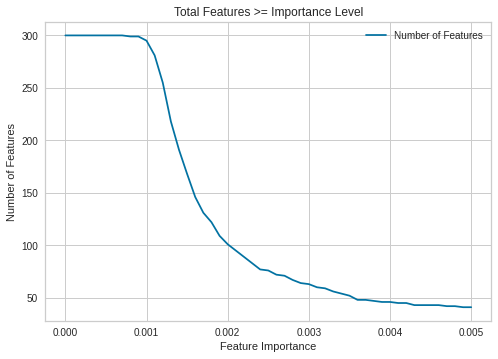

In [15]:
# Analyze model features for importance for feature trimming
myEM.analyzeModelFeatureImportance(experiment_index=0, #Which model to use as surrogate for feature importance
                                   startValue=0,
                                   upperValue=0.005,
                                   returnAbove=0.0015,
                                   process_package=True,
                                   num_cores=15,
                                   apply_features=False)

Experiment index[0]XGB depth:10 est:100 model already created


  0%|          | 0/102 [00:00<?, ?it/s]

Feature Importance Summary:
---> Original feature count: 300
---> Returned feature count: 101
---> Removed feature count: 199
---> Return items above (including): 0.002
Important features kept:
['abdominal', 'action', 'active', 'acute', 'admitting', 'airway', 'allergy', 'antibiotic', 'aortic', 'area', 'artery', 'assessment', 'atrial', 'attending', 'baby', 'bili', 'cabg', 'cardiac', 'cath', 'cckgday', 'chest', 'chronic', 'cmho', 'code', 'command', 'contrast', 'coronary', 'cough', 'cpap', 'data', 'delivery', 'disease', 'distress', 'doppler', 'drain', 'drainage', 'effusion', 'event', 'failure', 'feed', 'fever', 'foley', 'goal', 'head', 'hemorrhage', 'heparin', 'hypertension', 'hypotension', 'infant', 'insulin', 'intubated', 'lasix', 'lastname', 'leaflet', 'left', 'meql', 'mgdl', 'mitral', 'mmhg', 'murmur', 'neonatology', 'neuro', 'note', 'pain', 'patient', 'peep', 'picc', 'please', 'pneumonia', 'portable', 'pulse', 'radiology', 'reason', 'renal', 'report', 'resp', 'respiratory', 'response

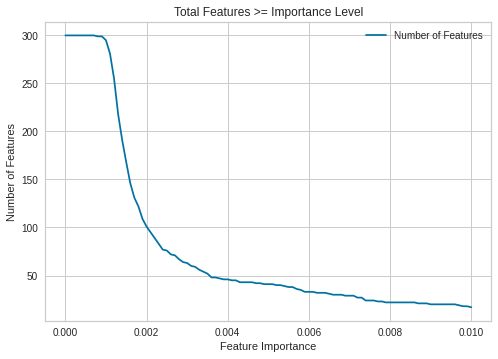

In [18]:
# Analyze model features for importance for feature trimming
myEM.analyzeModelFeatureImportance(experiment_index=0, #Which model to use as surrogate for feature importance
                                   startValue=0,
                                   upperValue=0.01,
                                   returnAbove=0.002,
                                   process_package=True,
                                   num_cores=15,
                                   apply_features=True)

# ExperimentManager - run_experiment

In [19]:
myEM.list_experiments()

idx Processed       Method Experiment name               
  0     False   supervised XGB depth:10 est:100
  1     False   supervised XGB depth:20 est:200
  2     False   supervised XGB depth:25 est:200
  3     False   supervised RF depth:10 est:100
  4     False   supervised RF depth:20 est:200
  5     False   supervised RF depth:25 est:200
  6     False unsupervised KMeans n=10


---------------------------------------------------------------------------
Data package has already been processed


---------------------------------------------------------------------------
Processing experiment: [0] XGB depth:10 est:100

Training model for XGB depth:10 est:100. <class 'xgboost.sklearn.XGBClassifier'>
Completed. Wall time[h:m:s]: 00:00:29
Predicting model for XGB depth:10 est:100. <class 'xgboost.sklearn.XGBClassifier'>
<class 'xgboost.sklearn.XGBClassifier'>
Supervised model being processed. Calling predictProba
Completed. Wall time[h:m:s]: 00:00:00

Model Stats:


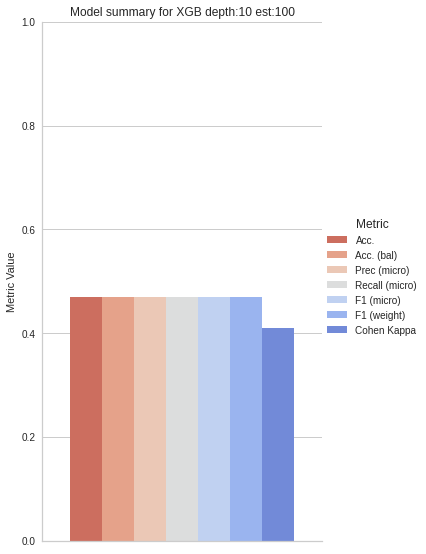

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:10 est:100,0.47,0.47,0.47,0.47,0.47,0.47,0.41




Completed. Wall time[h:m:s]: 00:00:30


---------------------------------------------------------------------------
Processing experiment: [1] XGB depth:20 est:200

Training model for XGB depth:20 est:200. <class 'xgboost.sklearn.XGBClassifier'>
Completed. Wall time[h:m:s]: 00:04:33
Predicting model for XGB depth:20 est:200. <class 'xgboost.sklearn.XGBClassifier'>
<class 'xgboost.sklearn.XGBClassifier'>
Supervised model being processed. Calling predictProba
Completed. Wall time[h:m:s]: 00:00:01

Model Stats:


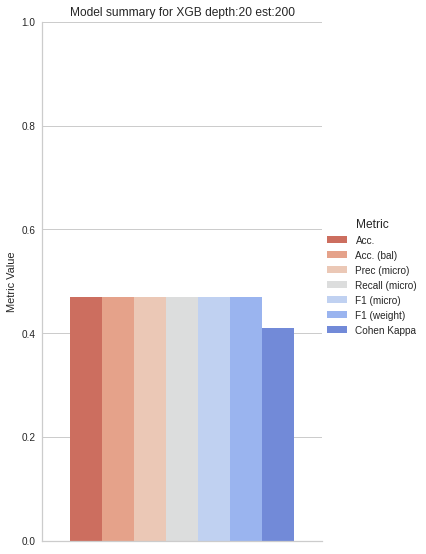

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:20 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41




Completed. Wall time[h:m:s]: 00:04:35


---------------------------------------------------------------------------
Processing experiment: [2] XGB depth:25 est:200

Training model for XGB depth:25 est:200. <class 'xgboost.sklearn.XGBClassifier'>
Completed. Wall time[h:m:s]: 00:09:11
Predicting model for XGB depth:25 est:200. <class 'xgboost.sklearn.XGBClassifier'>
<class 'xgboost.sklearn.XGBClassifier'>
Supervised model being processed. Calling predictProba
Completed. Wall time[h:m:s]: 00:00:01

Model Stats:


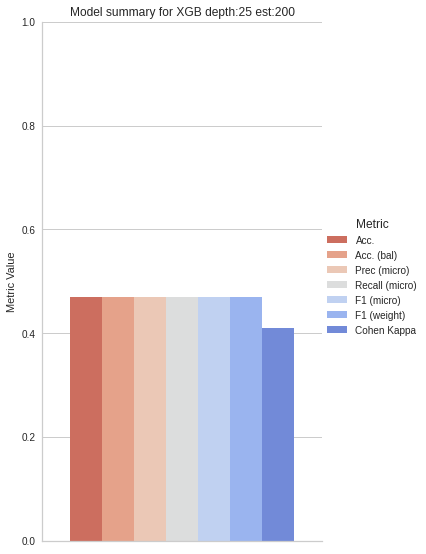

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:25 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41




Completed. Wall time[h:m:s]: 00:09:13


---------------------------------------------------------------------------
Processing experiment: [3] RF depth:10 est:100

Training model for RF depth:10 est:100. <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Completed. Wall time[h:m:s]: 00:00:03
Predicting model for RF depth:10 est:100. <class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Supervised model being processed. Calling predictProba
Completed. Wall time[h:m:s]: 00:00:00

Model Stats:


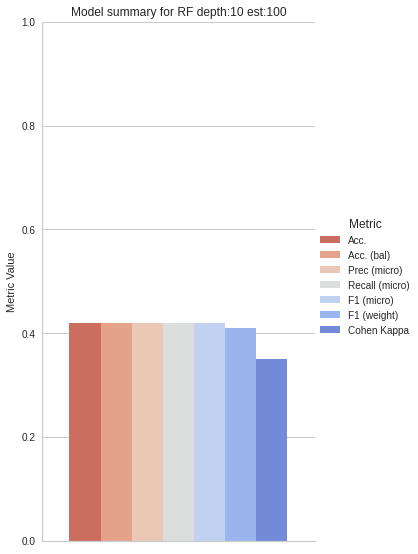

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
RF depth:10 est:100,0.42,0.42,0.42,0.42,0.42,0.41,0.35




Completed. Wall time[h:m:s]: 00:00:04


---------------------------------------------------------------------------
Processing experiment: [4] RF depth:20 est:200

Training model for RF depth:20 est:200. <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Completed. Wall time[h:m:s]: 00:00:12
Predicting model for RF depth:20 est:200. <class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Supervised model being processed. Calling predictProba
Completed. Wall time[h:m:s]: 00:00:00

Model Stats:


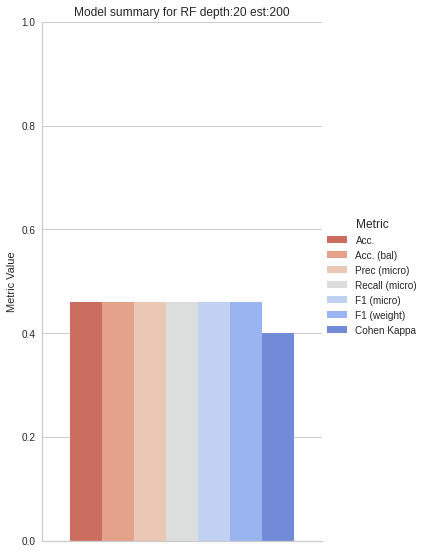

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
RF depth:20 est:200,0.46,0.46,0.46,0.46,0.46,0.46,0.4




Completed. Wall time[h:m:s]: 00:00:13


---------------------------------------------------------------------------
Processing experiment: [5] RF depth:25 est:200

Training model for RF depth:25 est:200. <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Completed. Wall time[h:m:s]: 00:00:14
Predicting model for RF depth:25 est:200. <class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Supervised model being processed. Calling predictProba
Completed. Wall time[h:m:s]: 00:00:01

Model Stats:


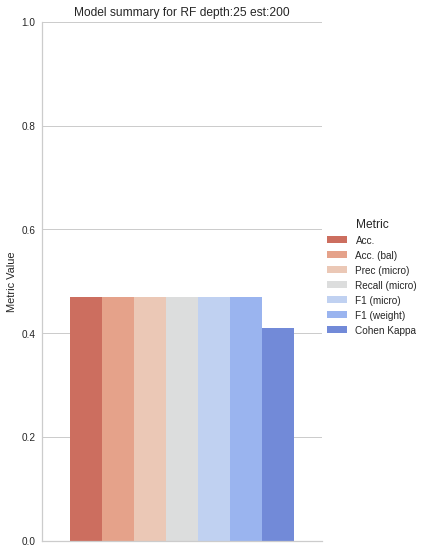

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
RF depth:25 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41




Completed. Wall time[h:m:s]: 00:00:15


---------------------------------------------------------------------------
Processing experiment: [6] KMeans n=10

Training model for KMeans n=10. <class 'sklearn.cluster._kmeans.KMeans'>
Completed. Wall time[h:m:s]: 00:00:06
Predicting model for KMeans n=10. <class 'sklearn.cluster._kmeans.KMeans'>
Unsupervised model being processed. no predict proba
Completed. Wall time[h:m:s]: 00:00:00

Model Stats:


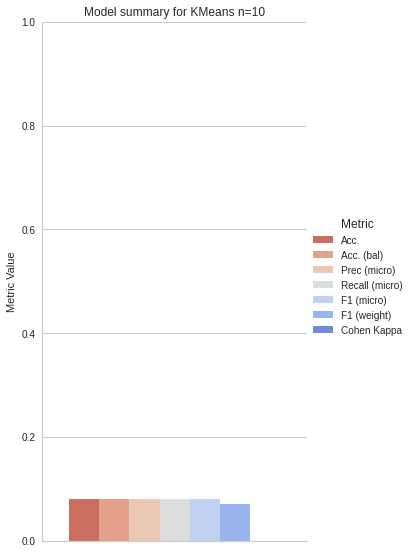

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
KMeans n=10,0.08,0.08,0.08,0.08,0.08,0.07,-0.03




Completed. Wall time[h:m:s]: 00:00:07


Processing complete. Displaying model comparison


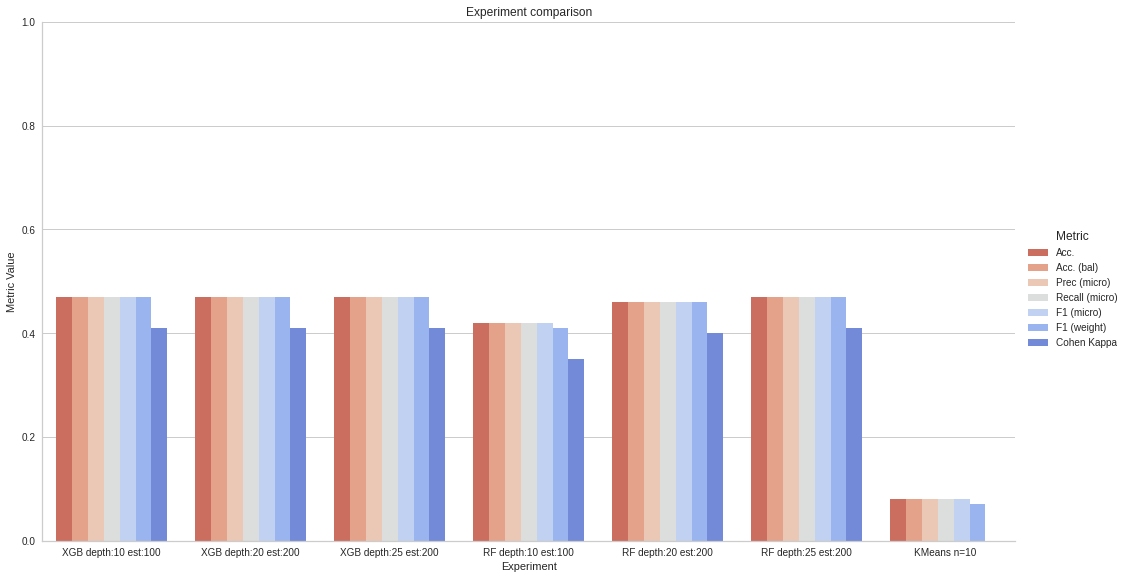

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:10 est:100,0.47,0.47,0.47,0.47,0.47,0.47,0.41
XGB depth:20 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41
XGB depth:25 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41
RF depth:10 est:100,0.42,0.42,0.42,0.42,0.42,0.41,0.35
RF depth:20 est:200,0.46,0.46,0.46,0.46,0.46,0.46,0.40
RF depth:25 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41
KMeans n=10,0.08,0.08,0.08,0.08,0.08,0.07,-0.03



Processing experiments complete. Wall time[h:m:s]: 00:14:59


In [20]:
myEM.run_experiment(index=None, # index=None means process all experiements, 
                    num_cores=15 # num parallel processes to process text cleaning
                    )
                                # otherwise provide index of single experiment to run

# Create unsupervised mapping

In [21]:
# Which experiment index is the unsupervised
unsupervised_experiment=6

In [22]:
_ = myEM.experiments[unsupervised_experiment].get_unsupervised_mapping(showNumResults=5,
                                                 auto_mapping=True)


Current results of comparison between clusters and actuals
   y_test  y_pred  record_count
0       2       1          2160
1       5       1          2133
2       4       1          2085
3       1       1          2029
4       3       1          1804
Unique values in y_test: 10
Unique values in y_pred: 10
Unique values in y_test and y_pred: 10
Number of rows/combinations: 87

All mappings appear in predictions. All good
Auto mapping the results
Mapping predicted to actual: {1: 2, 8: 4, 0: 9, 3: 8, 4: 6, 9: 0, 7: 1, 5: 5, 6: 7, 2: 3}


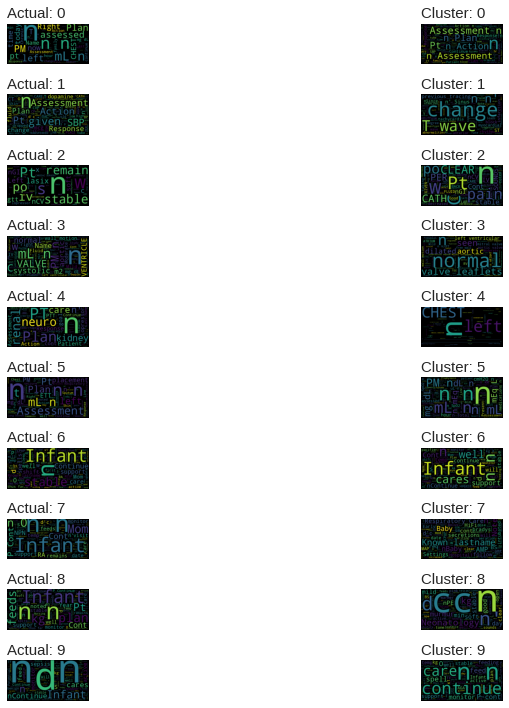

In [23]:
myEM.experiments[unsupervised_experiment].show_cluster_mapping_cloud()

Processing complete. Displaying model comparison


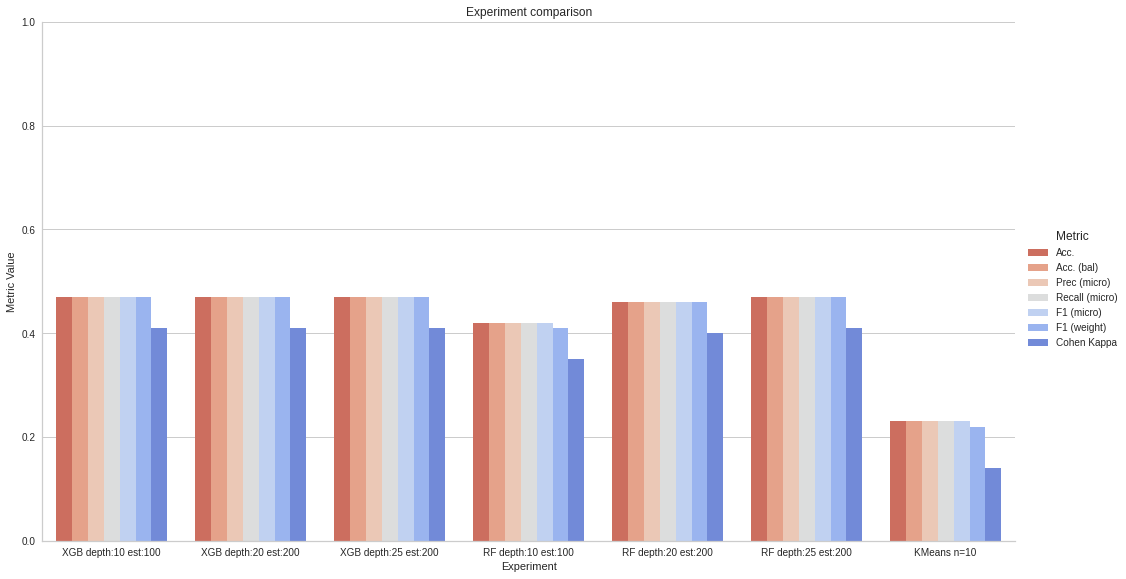

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:10 est:100,0.47,0.47,0.47,0.47,0.47,0.47,0.41
XGB depth:20 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41
XGB depth:25 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41
RF depth:10 est:100,0.42,0.42,0.42,0.42,0.42,0.41,0.35
RF depth:20 est:200,0.46,0.46,0.46,0.46,0.46,0.46,0.40
RF depth:25 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41
KMeans n=10,0.23,0.23,0.23,0.23,0.23,0.22,0.14


In [24]:
_ = myEM.show_model_comparison()

# Show representative experiment Summary


Model Stats:


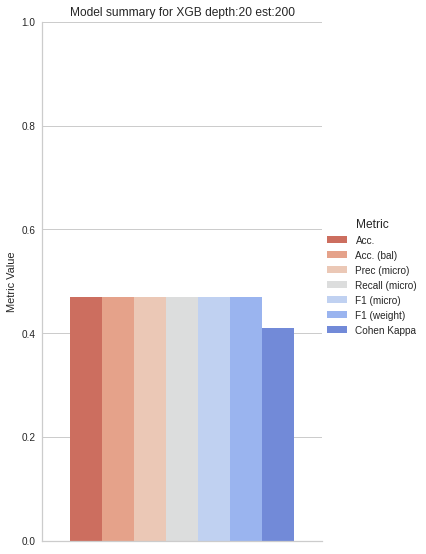

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:20 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41



              precision    recall  f1-score   support

           0       0.59      0.55      0.57      5145
           1       0.46      0.44      0.45      5146
           2       0.47      0.55      0.51      5146
           3       0.61      0.57      0.59      5146
           4       0.75      0.71      0.73      5145
           5       0.52      0.56      0.54      5145
           6       0.33      0.33      0.33      5146
           7       0.29      0.28      0.29      5146
           8       0.29      0.28      0.29      5145
           9       0.36      0.37      0.37      5146

    accuracy                           0.47     51456
   macro avg       0.47      0.47      0.47     51456
weighted avg       0.47      0.47      0.47     51456



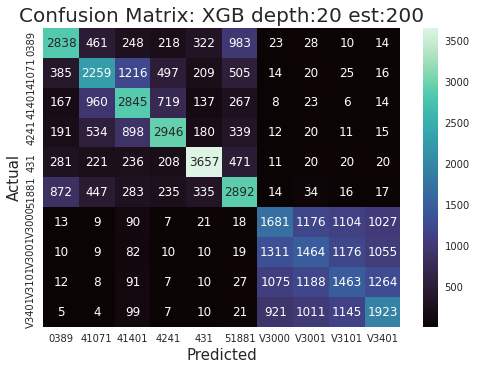

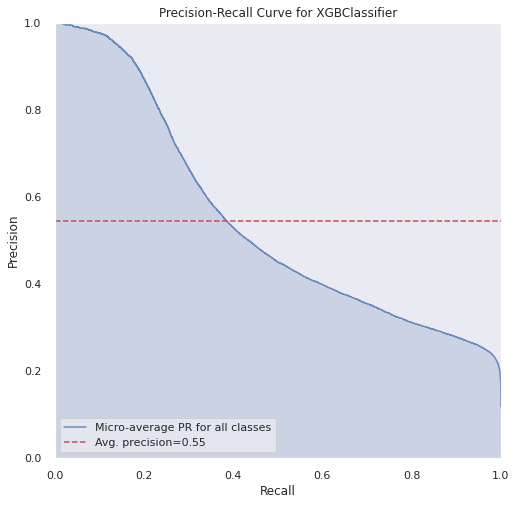

Model Learning curve has not yet been calculated. Calculating now


<Figure size 576x576 with 0 Axes>

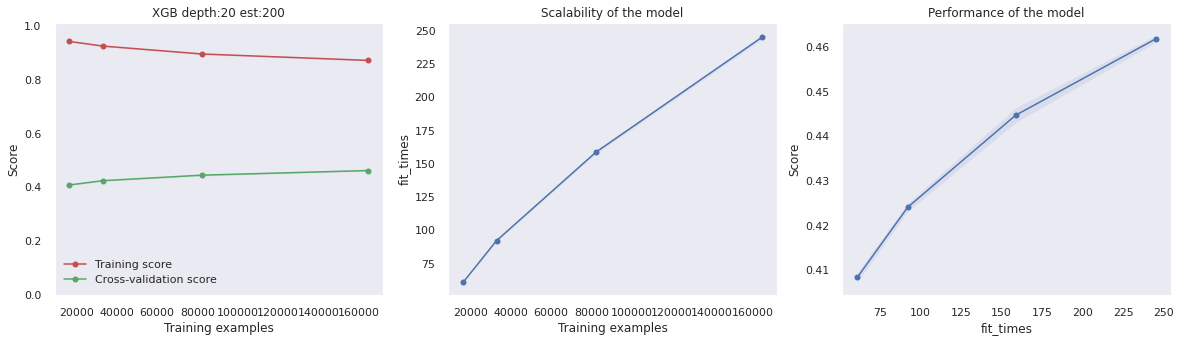

Model ROCAUC not calculated. Calculating now


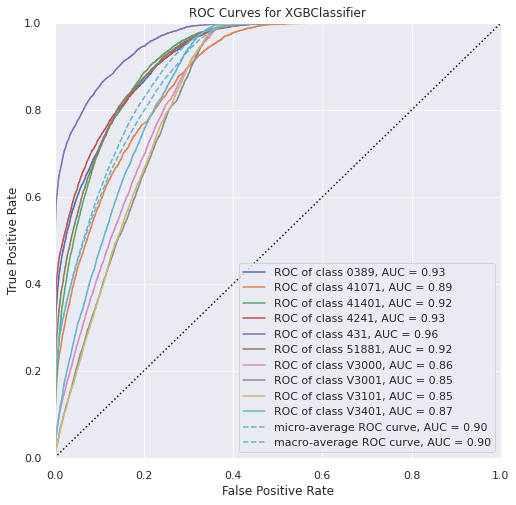

  0%|          | 0/101 [00:00<?, ?it/s]

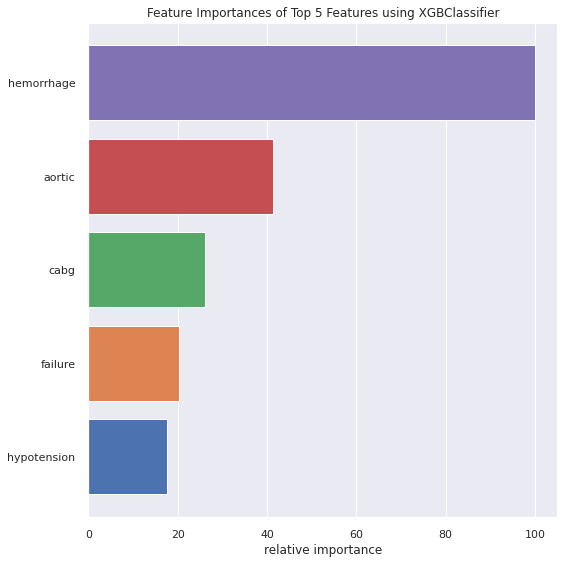

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


<Figure size 576x576 with 0 Axes>

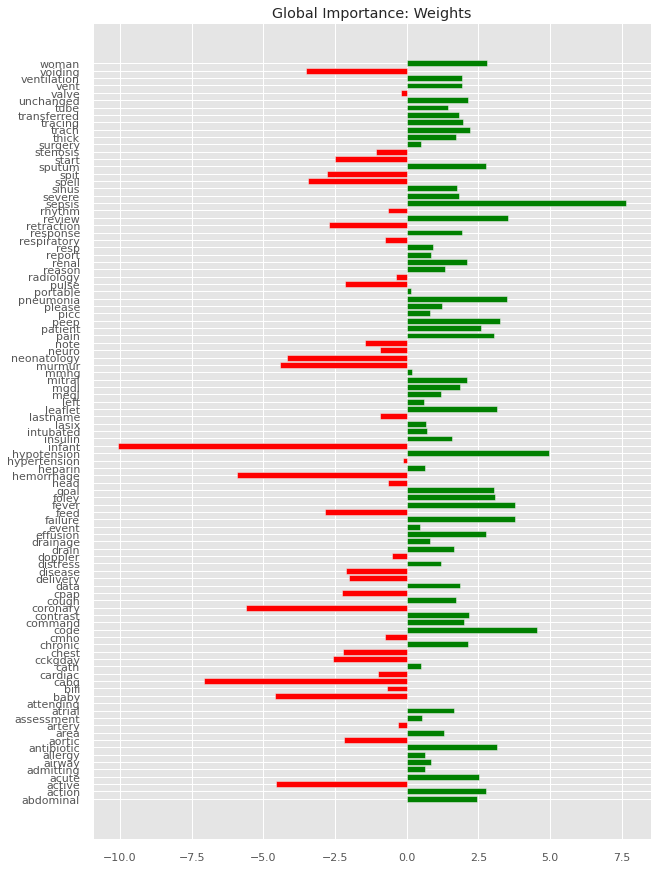

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


predicted [9]
actual 7


X does not have valid feature names, but LogisticRegression was fitted with feature names


CPU times: user 24min 48s, sys: 43min 55s, total: 1h 8min 43s
Wall time: 56min 15s


<Figure size 576x576 with 0 Axes>

In [25]:
%%time
representative_experiment = 1
myEM.experiments[representative_experiment].showFullModelReport()

# Add additional models

In [26]:
# Create the optimizer and parameters for processing the CNN model

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

tp = TensorParms(loss='sparse_categorical_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'],
                 validation_split=0.25,
                 epochs=25,
                 batch_size=32,
                 shuffle=True,
                 verbose=1)

# Num features to process
input_size = len(myEM.data_package.dataFeatures)

# Num classes
output_size = NUM_UNIQUE_ICD9_CODES

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from keras.layers import BatchNormalization

untrained_CNN1 = Sequential()
untrained_CNN1.add(Conv1D(32, 3, activation='relu', input_shape = (input_size,1)))
untrained_CNN1.add(BatchNormalization()) 
untrained_CNN1.add(Dropout(0.5)) 
untrained_CNN1.add(MaxPooling1D(2))
untrained_CNN1.add(Flatten())
untrained_CNN1.add(Dense(100, activation='relu'))
untrained_CNN1.add(Dense(output_size, activation='softmax'))


myEM.add_experiment(experiment_name=f'CNN input:{input_size} classes:{output_size}',
                    experiment_method='supervised',
                    untrained_model=untrained_CNN1)

2022-10-21 17:39:41.331012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero



DataExperiment summary:
---> projectName: mimiciii_LL
---> experimentName: CNN input:101 classes:10
---> experimentMethod: supervised
---> isDataPackageLoaded: True
---> isProcessed: False
---> isModelLoaded: False
---> isModelPredicted: False
---> isLearningCurveCreated: False
---> isUntrainedModelLoaded: True


2022-10-21 17:39:41.331602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 17:39:41.368368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 17:39:41.368766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 17:39:41.369095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 17:39:41.369399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

INFO:tensorflow:Assets written to: ram://5ee56b5c-4c53-471d-b5f5-69015340062d/assets

<class 'keras.engine.sequential.Sequential'>


In [28]:
myEM.list_experiments()


idx Processed       Method Experiment name               
  0      True   supervised XGB depth:10 est:100
  1      True   supervised XGB depth:20 est:200
  2      True   supervised XGB depth:25 est:200
  3      True   supervised RF depth:10 est:100
  4      True   supervised RF depth:20 est:200
  5      True   supervised RF depth:25 est:200
  6      True unsupervised KMeans n=10
  7     False   supervised CNN input:101 classes:10


---------------------------------------------------------------------------
Data package has already been processed

Processing experiment: CNN input:101 classes:10
Training model for CNN input:101 classes:10. <class 'keras.engine.sequential.Sequential'>
Keras model detected. compiling and training
INFO:tensorflow:Assets written to: ram://5f60fa66-9c7d-43fb-944a-d73e391ee9a7/assets


2022-10-21 17:39:43.811941: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8500


Completed. Wall time[h:m:s]: 00:06:21
Predicting model for CNN input:101 classes:10. <class 'keras.engine.sequential.Sequential'>
<class 'keras.engine.sequential.Sequential'>
Unsupervised model being processed. no predict proba
Completed. Wall time[h:m:s]: 00:00:03

Model Stats:


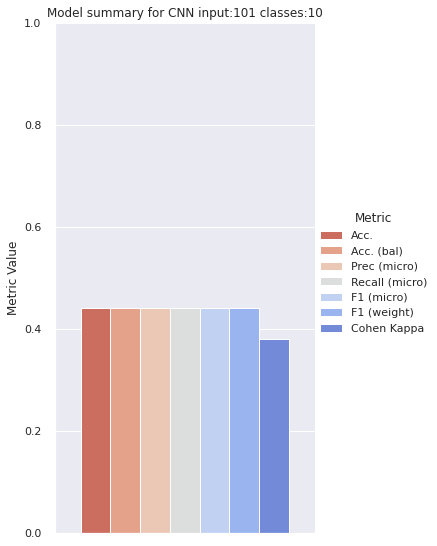

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
CNN input:101 classes:10,0.44,0.44,0.44,0.44,0.44,0.44,0.38




Processing complete. Displaying model comparison


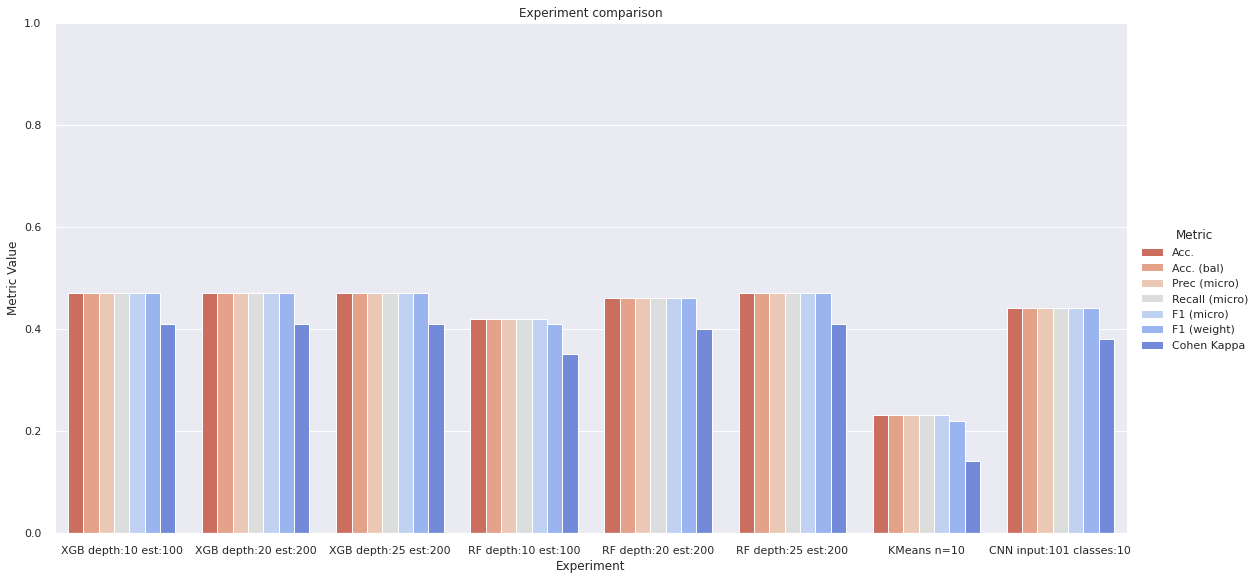

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:10 est:100,0.47,0.47,0.47,0.47,0.47,0.47,0.41
XGB depth:20 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41
XGB depth:25 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41
RF depth:10 est:100,0.42,0.42,0.42,0.42,0.42,0.41,0.35
RF depth:20 est:200,0.46,0.46,0.46,0.46,0.46,0.46,0.40
RF depth:25 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41
KMeans n=10,0.23,0.23,0.23,0.23,0.23,0.22,0.14
CNN input:101 classes:10,0.44,0.44,0.44,0.44,0.44,0.44,0.38



Processing experiments complete. Wall time[h:m:s]: 00:06:24


In [29]:
myEM.run_experiment(index=7,
                    num_cores=15)

# Show final metric comparison

Processing complete. Displaying model comparison


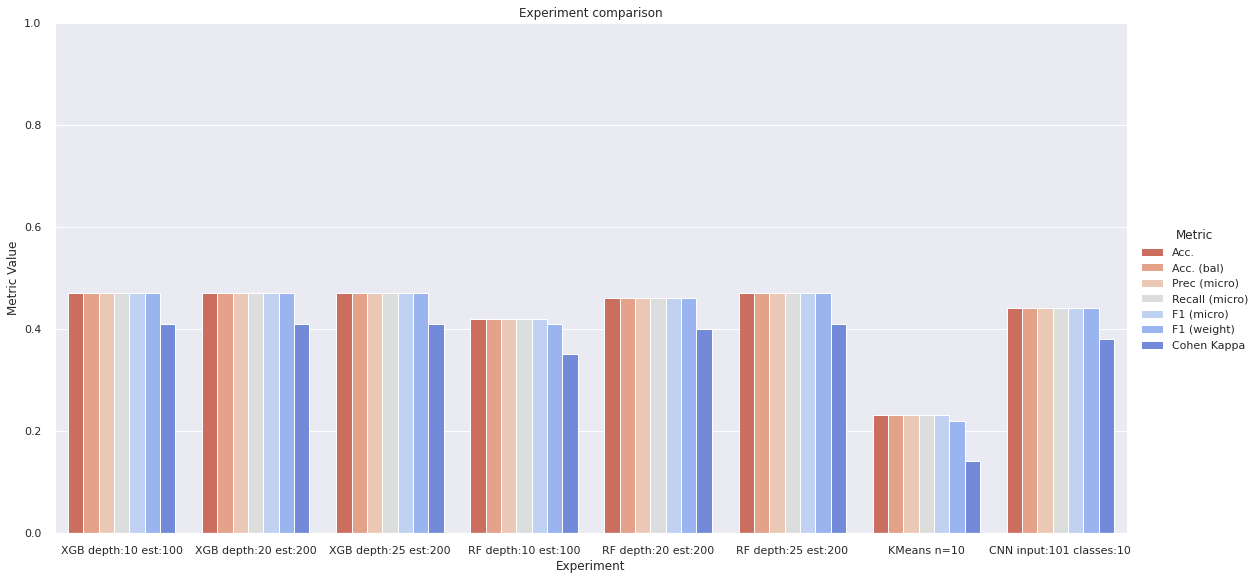

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:10 est:100,0.47,0.47,0.47,0.47,0.47,0.47,0.41
XGB depth:20 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41
XGB depth:25 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41
RF depth:10 est:100,0.42,0.42,0.42,0.42,0.42,0.41,0.35
RF depth:20 est:200,0.46,0.46,0.46,0.46,0.46,0.46,0.40
RF depth:25 est:200,0.47,0.47,0.47,0.47,0.47,0.47,0.41
KMeans n=10,0.23,0.23,0.23,0.23,0.23,0.22,0.14
CNN input:101 classes:10,0.44,0.44,0.44,0.44,0.44,0.44,0.38


In [30]:
_ = myEM.show_model_comparison()

# Scratchpad